# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>
#include <cmath>

// Use (void) to silent unused warnings.
#define assertm(exp, msg) assert(((void)msg, exp))

In [2]:
class MyDataset : public torch::data::Dataset<MyDataset>
{
    private:
        torch::Tensor states_, labels_;

    public:
        explicit MyDataset(torch::Tensor states, torch::Tensor labels) 
            : states_(states),
              labels_(labels) {   };

        torch::data::Example<> get(size_t index) override {
            return {states_[index], labels_[index]};
        };

        torch::optional<size_t> size() const override {
            return states_.size(0);
        };
};

# 模型选择、欠拟合和过拟合

### 使用以下三阶多项式来生成训练和测试数据的标签

$y = 5 + 1.2x - 3.4 \frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \quad where \quad\epsilon \sim \mathcal{N} (0,0.01^2)$

In [3]:
constexpr int max_degree = 20;
constexpr int n_train = 100;
constexpr int n_test = 100;

//多项式系数
torch::Tensor true_w = torch::zeros(max_degree);
float temp[] = {5.0, 1.2, -3.4, 5.6};
memcpy(true_w.data_ptr(), temp, sizeof(temp));

//准备输入
torch::Tensor features = torch::randint(-99999, 99999, {n_train + n_test, 1}) / 100000.0;
torch::Tensor poly_features  = features.clone();
poly_features = poly_features.pow(torch::arange(max_degree));

for (int i = 0; i < max_degree; i++) {
    int factorial = 1;
    if(i != 0) factorial = tgamma(i);
    for (int row = 0; row < (n_train + n_test); row++) {
        poly_features[row][i] /= factorial;
    }
}

// printT(features);
// printT(poly_features);

//生成输出
true_w = true_w.reshape({max_degree, 1});
// printT(true_w);
torch::Tensor labels = poly_features.mm(true_w);
labels += torch::rand_like(labels) * 0.1;

In [4]:
printT(features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
  
printT(poly_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None)}));    

printT(labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

features.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 0.1357
-0.3322
[ CPUFloatType{2,1} ]
<<--->>

poly_features.index({torch::indexing::Slice(torch::indexing::None, 1, torch::indexing::None)}) = 
Columns 1 to 6 1.0000e+00  1.3571e-01  1.8417e-02  1.2497e-03  5.6532e-05  1.9180e-06

Columns 7 to 12 5.2058e-08  1.1775e-09  2.2828e-11  3.8725e-13  5.8392e-15  7.9244e-17

Columns 13 to 18 9.7766e-19  1.1056e-20 -3.3468e-22 -4.5420e-23 -6.1640e-24 -8.3651e-25

Columns 19 to 20-1.1352e-25 -1.5406e-26
[ CPUFloatType{1,20} ]
<<--->>

labels.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.1119
 4.2234
[ CPUFloatType{2,1} ]
<<--->>



### 定义训练函数

In [5]:
std::vector<int> x;
std::vector<double> y;
std::vector<double> y_hat;

In [6]:
torch::Tensor train(torch::Tensor train_features, 
           torch::Tensor test_features, 
           torch::Tensor train_labels, 
           torch::Tensor test_labels,
           int num_epochs = 400,
           int batch_size = 10)
{
    assertm(train_features.dim() == 2, "train_features should have 2 dims");
    assertm(test_features.dim() == 2, "test_features should have 2 dims");
    
    auto train_data_set = MyDataset(train_features, train_labels)
//                                     .map(torch::data::transforms::Normalize<>(0, 0.5))
                                    .map(torch::data::transforms::Stack<>());
    auto test_data_set = MyDataset(test_features, test_labels)
//                                     .map(torch::data::transforms::Normalize<>(0, 0.5))
                                    .map(torch::data::transforms::Stack<>());

    auto train_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(train_data_set), 
                                    batch_size);

    auto test_data_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
                                    std::move(test_data_set), 
                                    batch_size);

    int input_shape = train_features.size(1);
    torch::nn::Sequential net({{"fc", torch::nn::Linear(torch::nn::LinearOptions(input_shape, 1).bias(false))}});
    
//     auto p = net->named_parameters(false);
//     auto w = p.find("weight");
//     auto b = p.find("bias");   
    
//     //if (w != nullptr) torch::nn::init::xavier_uniform_(*w);
//     if (w != nullptr) torch::nn::init::uniform_(*w, -1, 1);
//     //if (w != nullptr) torch::nn::init::normal_(*w);
//     if (b != nullptr) torch::nn::init::constant_(*b, 0.01);
    
//     auto optimizer = torch::optim::SGD(net->parameters(), torch::optim::SGDOptions(0.01).momentum(0.5));
    auto optimizer = torch::optim::SGD(net->parameters(), /*lr*/0.01);
    
        
    for (int epoch = 0; epoch < num_epochs; epoch++) 
    {
        torch::Tensor loss_values;
        if (epoch % 10 == 0) x.push_back(epoch);
        
        for (auto& batch : *train_data_loader) {
            auto data = batch.data;
            auto labels = batch.target;

//             optimizer.zero_grad();
            net->zero_grad();
            auto training_prediction = net->forward(data);
            loss_values = torch::mse_loss(training_prediction, labels);
            loss_values = loss_values.sum() / training_prediction.size(0);
            loss_values.backward(); 
            optimizer.step();
        }
        if (epoch % 10 == 0) 
//             y.push_back(loss_values.max().item<double>());
            y.push_back(loss_values.sum().item<double>() / batch_size);
        
        auto test_prediction = net->forward(test_features);
        auto test_loss_values = torch::mse_loss(test_prediction, test_labels);
        if (epoch % 10 == 0) 
//             y_hat.push_back(test_loss_values.max().item<double>());        
            y_hat.push_back(torch::sum(test_loss_values).item<double>() / test_prediction.size(0));        
        
        if (epoch % (num_epochs/10) == 0) {
        // Report the error with respect to y_training. 
        double sum_loss = loss_values.sum().item<double>();
        std::cout << "Epoch " << epoch 
            << ", sum(loss_values) = " << sum_loss << std::endl;
        }
    }
    
    std::cout << net->parameters() << std::endl;
    return net->parameters()[0];
}

In [7]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 4, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 1.0000  0.1357  0.0184  0.0012
 1.0000 -0.3322  0.1103 -0.0183
[ CPUFloatType{2,4} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.1119
 4.2234
[ CPUFloatType{2,1} ]
<<--->>



### 训练并验证

In [8]:
auto w = train(train_data, test_data, train_label, test_label, 1000);

Epoch 0, sum(loss_values) = 2.13922
Epoch 100, sum(loss_values) = 0.296423
Epoch 200, sum(loss_values) = 0.1143
Epoch 300, sum(loss_values) = 0.181997
Epoch 400, sum(loss_values) = 0.0479792
Epoch 500, sum(loss_values) = 0.0828451
Epoch 600, sum(loss_values) = 0.049644
Epoch 700, sum(loss_values) = 0.0280761
Epoch 800, sum(loss_values) = 0.0084533
Epoch 900, sum(loss_values) = 0.0301131
 4.6933  2.4324 -2.4164  1.4991
[ CPUFloatType{1,4} ]


In [9]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({4,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,4}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,4}).mm(w));

train_label[0] = 
 5.1119
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,4}).mm(w) = 
 4.9808
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 5.1443
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,4}).mm(w) = 
 5.3235
[ CPUFloatType{1,1} ]
<<--->>



### 训练结果可视化

In [10]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss(r:test  b:train)");
plt::legend();
plt::save("./loss.png"); 
plt::show();

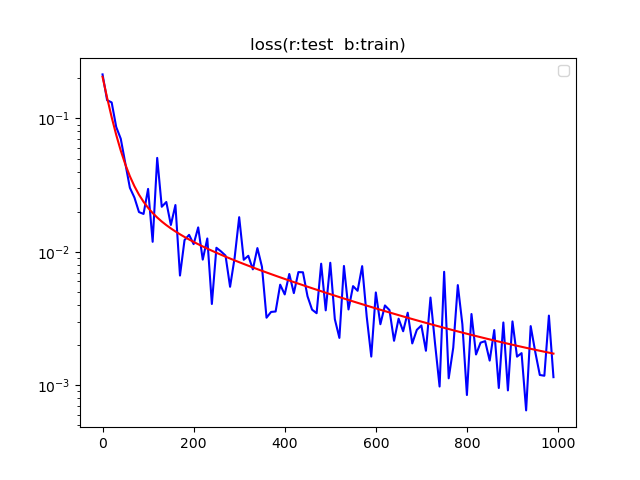

In [11]:
auto img1 = im::image("./loss.png");
img1  

# 欠拟合

In [12]:
auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, 2, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 1.0000  0.1357
 1.0000 -0.3322
[ CPUFloatType{2,2} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.1119
 4.2234
[ CPUFloatType{2,1} ]
<<--->>



In [13]:
std::vector <int>().swap(x);
std::vector <double>().swap(y);
std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label, 1000);

Epoch 0, sum(loss_values) = 2.14197
Epoch 100, sum(loss_values) = 0.153931
Epoch 200, sum(loss_values) = 0.171755
Epoch 300, sum(loss_values) = 0.0702179
Epoch 400, sum(loss_values) = 0.0643705
Epoch 500, sum(loss_values) = 0.0454866
Epoch 600, sum(loss_values) = 0.196831
Epoch 700, sum(loss_values) = 0.114266
Epoch 800, sum(loss_values) = 0.0746149
Epoch 900, sum(loss_values) = 0.263473
 3.9311  2.8400
[ CPUFloatType{1,2} ]


In [14]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({2,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,2}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,2}).mm(w));

train_label[0] = 
 5.1119
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,2}).mm(w) = 
 4.3165
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 5.1443
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,2}).mm(w) = 
 5.0536
[ CPUFloatType{1,1} ]
<<--->>



In [15]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_underfit(r:test  b:train)");
plt::legend();
plt::save("./loss_underfit.png"); 
plt::show();

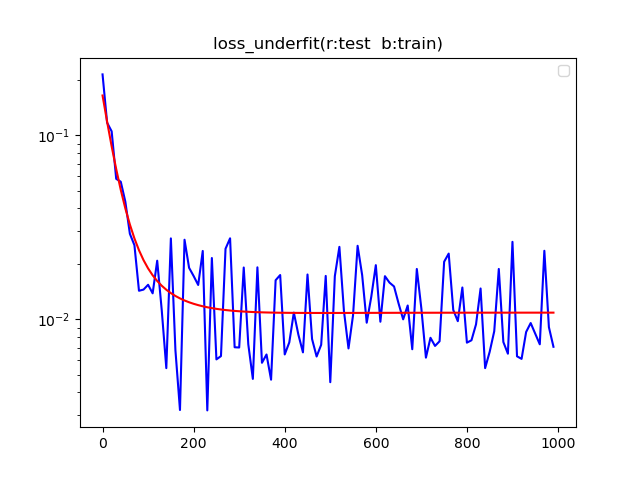

In [16]:
auto img2 = im::image("./loss_underfit.png");
img2

# 过拟合

In [17]:
#define W_OVERFIT (20)

auto train_data = 
    poly_features.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});
auto train_label = 
    labels.index({torch::indexing::Slice(0, n_train, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});

auto test_data = 
    poly_features.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});
auto test_label = 
    labels.index({torch::indexing::Slice(n_train, torch::indexing::None, torch::indexing::None),
                         torch::indexing::Slice(0, W_OVERFIT, torch::indexing::None)});


printT(train_data.size(0));
printT(train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    
printT(train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}));    

train_data.size(0) = 
100
<<--->>

train_data.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
Columns 1 to 6 1.0000e+00  1.3571e-01  1.8417e-02  1.2497e-03  5.6532e-05  1.9180e-06
 1.0000e+00 -3.3217e-01  1.1034e-01 -1.8325e-02  2.0290e-03 -1.6850e-04

Columns 7 to 12 5.2058e-08  1.1775e-09  2.2828e-11  3.8725e-13  5.8392e-15  7.9244e-17
 1.1194e-05 -6.1971e-07  2.9407e-08 -1.2210e-09  4.5065e-11 -1.4969e-12

Columns 13 to 18 9.7766e-19  1.1056e-20 -3.3468e-22 -4.5420e-23 -6.1640e-24 -8.3651e-25
 4.5203e-14 -1.2513e-15 -9.2708e-17  3.0795e-17 -1.0229e-17  3.3978e-18

Columns 19 to 20-1.1352e-25 -1.5406e-26
-1.1286e-18  3.7490e-19
[ CPUFloatType{2,20} ]
<<--->>

train_label.index({torch::indexing::Slice(torch::indexing::None, 2, torch::indexing::None)}) = 
 5.1119
 4.2234
[ CPUFloatType{2,1} ]
<<--->>



In [18]:
if(!x.empty()) std::vector <int>().swap(x);
if(!y.empty()) std::vector <double>().swap(y);
if(!y_hat.empty()) std::vector <double>().swap(y_hat);

auto w = train(train_data, test_data, train_label, test_label, 1000);

Epoch 0, sum(loss_values) = 1.55226
Epoch 100, sum(loss_values) = 0.231756
Epoch 200, sum(loss_values) = 0.138789
Epoch 300, sum(loss_values) = 0.0561807
Epoch 400, sum(loss_values) = 0.0642184
Epoch 500, sum(loss_values) = 0.028574
Epoch 600, sum(loss_values) = 0.0312746
Epoch 700, sum(loss_values) = 0.0287587
Epoch 800, sum(loss_values) = 0.0165625
Epoch 900, sum(loss_values) = 0.0148376
Columns 1 to 10 4.6964  2.5433 -2.3865  1.1251 -0.4087  0.0964 -0.1942 -0.1322  0.1636  0.1326

Columns 11 to 20-0.1469  0.0172  0.1257  0.0907  0.1914 -0.1090  0.0842  0.0603  0.0428 -0.0491
[ CPUFloatType{1,20} ]


In [19]:
//true_w
// = {5.0, 1.2, -3.4, 5.6};

w = w.reshape({W_OVERFIT,1});
printT(train_label[0]);
printT(train_data[0].reshape({1,W_OVERFIT}).mm(w));

printT(test_label[3]);
printT(test_data[3].reshape({1,W_OVERFIT}).mm(w));

train_label[0] = 
 5.1119
[ CPUFloatType{1} ]
<<--->>

train_data[0].reshape({1,W_OVERFIT}).mm(w) = 
 4.9990
[ CPUFloatType{1,1} ]
<<--->>

test_label[3] = 
 5.1443
[ CPUFloatType{1} ]
<<--->>

test_data[3].reshape({1,W_OVERFIT}).mm(w) = 
 5.3619
[ CPUFloatType{1,1} ]
<<--->>



In [20]:
plt::semilogy(x, y, "b");
plt::semilogy(x, y_hat, "r");

plt::title("loss_overfit(r:test  b:train)");
plt::legend();
plt::save("./loss_overfit.png"); 
plt::show();

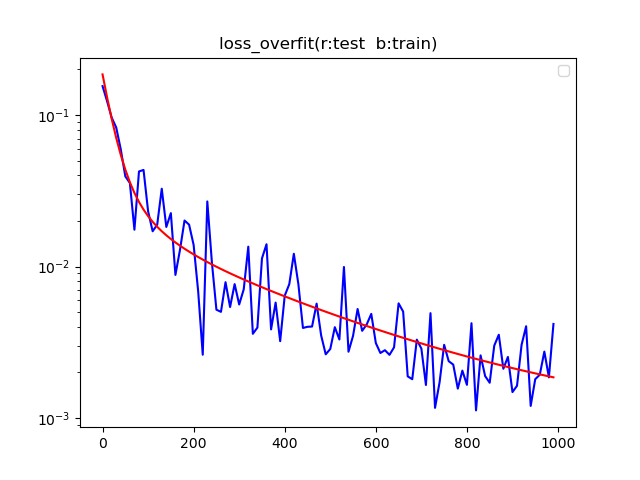

In [21]:
auto img2 = im::image("./loss_overfit.png");
img2